In [24]:
import torch
import torch_geometric
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from scipy.stats import ortho_group, special_ortho_group
from collections import Counter

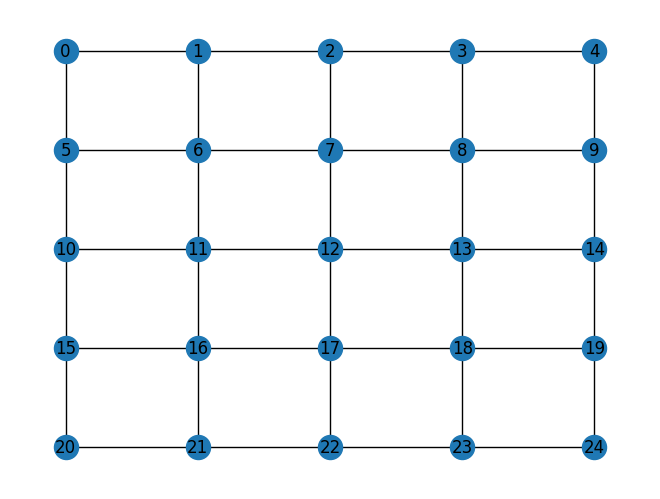

In [25]:
# create a 2D grid graph
k1 = 5
k2 = 5
grid = nx.grid_2d_graph(k1, k2)
n = k1 * k2
grid = nx.convert_node_labels_to_integers(grid)

# make grid undirected
grid = grid.to_undirected()
# add edges in the opposite direction
# grid.add_edges_from([(v, u) for (u, v) in grid.edges()])

# plot the graph
# create 2D coordinates
pos = dict()
for i in range(k1):
    for j in range(k2):
        pos[i * k2 + j] = (j, -i)

nx.draw(grid, pos=pos, with_labels=True)

In [26]:
# duplicate the grid so we have two connected components
grid2 = grid.copy()
two_grids = nx.disjoint_union(grid, grid2)

[(0, 5), (0, 1), (1, 6), (1, 2), (2, 7), (2, 3), (3, 8), (3, 4), (4, 9), (5, 10)]


C:\Users\guyle\AppData\Local\Temp\ipykernel_4500\564662386.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("coolwarm")
C:\Users\guyle\AppData\Local\Temp\ipykernel_4500\564662386.py:29: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


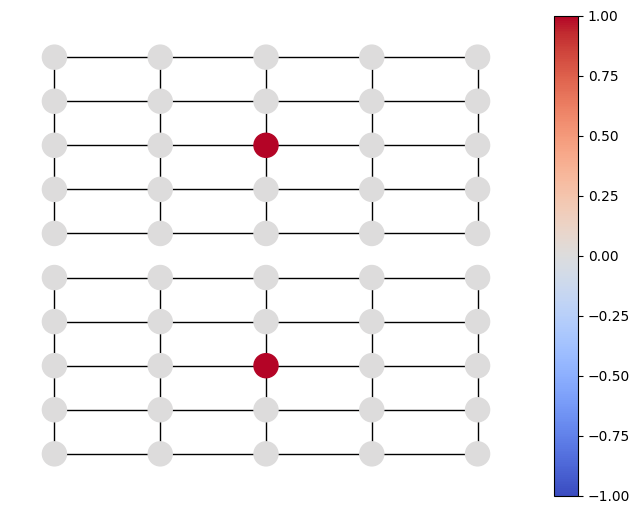

In [27]:
edges = list(two_grids.edges)
# add edges in the opposite direction
edges.extend([(v, u) for (u, v) in two_grids.edges()])
print(edges[:10])

edge_index = torch.tensor(edges).t().contiguous()
x = torch.tensor(np.zeros((2*n, 1)), dtype=torch.float)
# x will be a spike signal in the middle of the two_grids
x[(n - 1)//2] = 1
x[n + (n - 1)//2] = 1
# x[42] = -1
data = Data(x=x, edge_index=edge_index)
data.validate(raise_on_error=True)

pos = dict()
for i in range(2):
    for j in range(k1):
        for k in range(k2):
            pos[i * n + j * k2 + k] = (k, -j - i * k1)

# create colormap that distinguishes between positive and negative values
cmap = plt.cm.get_cmap("coolwarm")

# visualize the spike signal
nx.draw(two_grids, pos=pos, node_color=data.x, cmap=cmap, with_labels=False, vmin=-1, vmax=1)
# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm)


C:\Users\guyle\AppData\Local\Temp\ipykernel_4500\1973914339.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


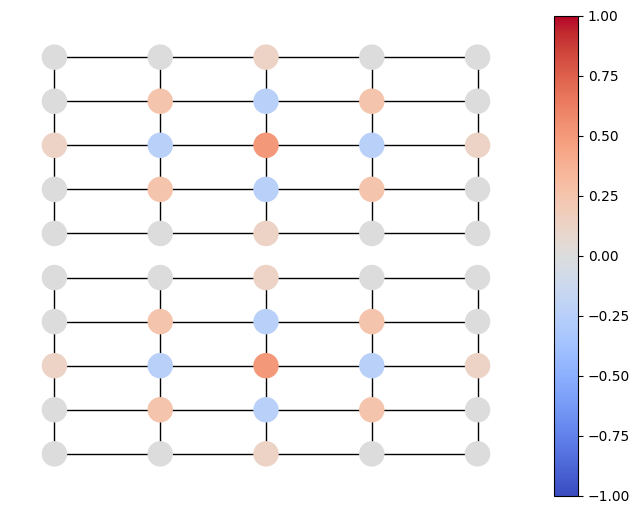

In [28]:
from torch_geometric.nn import ChebConv
# define a filter on a graph using pytorch geometric
class Filter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ChebConv(1, 1, K=4, bias=False, normalization='rw')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return x
 
filter = Filter()
# set the filter weights
set_param_to = np.array([[1],[1],[1],[0]], dtype=np.float32)

for idx, param in enumerate(filter.conv1.parameters()):
    param.data = torch.tensor(set_param_to[idx])

# for param in filter.conv1.parameters():
#     print(param)

out = filter(data)

# visualize the output

nx.draw(two_grids, pos=pos, node_color=out.detach().numpy(), with_labels=False, cmap="coolwarm", vmin=-1, vmax=1)
# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm)
plt.show()
